In [3]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from utils import (create_dir,
                    append_result_to_csv_file,
                    check_file_existence,
                    create_empty_result_csv_file)

from model import *
from plot import *

from data import *

Size of dataframe 0 is (64185, 9)
Size of dataframe 1 is (63204, 9)
Size of dataframe 2 is (48597, 9)
Size of dataframe 3 is (64454, 9)
April_8 data has been read
Size of dataframe 0 is (65571, 9)
Size of dataframe 1 is (64568, 9)
Size of dataframe 2 is (65350, 9)
Size of dataframe 3 is (66627, 9)
April_9 data has been read
Size of dataframe 0 is (62614, 9)
Size of dataframe 1 is (63825, 9)
Size of dataframe 2 is (63159, 9)
Size of dataframe 3 is (62531, 9)
April_10 data has been read
Size of dataframe 0 is (49762, 9)
Size of dataframe 1 is (61376, 9)
Size of dataframe 2 is (59725, 9)
Size of dataframe 3 is (61151, 9)
April_11 data has been read


In [4]:
IS_DIFF = False
IS_AVG = True
IS_PER = False

In [5]:
SENSOR_INDS_DICT={}
SENSOR_INDS_DICT["April_8"] = [[0, 2]]
SENSOR_INDS_DICT["April_9"] = [[1, 2]]
SENSOR_INDS_DICT["April_10"] = [[1, 3]]
SENSOR_INDS_DICT["April_11"] = [[0, 3]]

#DATA_INDS = [[0, 2], [0, 3], [1, 2], [1, 3]]
#DATA_INDS = [[1, 2]]

da_inds = [0]
ma_dirs = ["center", "before", "after"]
ma_vals = [0, 30, 60, 120, 240, 300, 600, 900]



In [6]:
data_dict_for_denoise = DATA_DICT

if IS_AVG:
    avg_data_dict = get_avg_data_dict()
    data_dict_for_denoise = avg_data_dict 
elif IS_PER:
    per_data_dict = get_per_data_dict()
    data_dict_for_denoise = per_data_dict 

In [7]:
def get_result_path():
    if IS_DIFF:
        path_out = os.path.join(PATH_ROOT, "results", "differencing_denoise_results.csv")
    elif IS_AVG:
        path_out = os.path.join(PATH_ROOT, "results", "averaged_denoise_results.csv")
    elif IS_PER:
        path_out = os.path.join(PATH_ROOT, "results", "percentage_denoise_results.csv")
    else:
        path_out = os.path.join(PATH_ROOT, "results", "normal_denoise_results.csv")
    return path_out

In [8]:
def run_denoise_experiments(data_dict, d_ind, remove_resist = True, moving_average = 0, 
                            moving_average_direction = "center", plot_detailed_results = False, 
                            plot_general_results = False, data_ind_pairs = None, 
                            is_standard_scaler = False, seed = 1234):
    #lstm_models = []
    
    path_out = get_result_path()
    #create_dir(path_out)
    print(check_file_existence(path_out))
    if check_file_existence(path_out) == False:
        # check the reslt file path, it file exists obtain new file name 
        first_result_line_list = ["date", "seed", "mse_control", "mse_experiment", "experiment_index", 
                                  "control_index", "is_diff", "is_avg", "is_per", "scaler_type", 
                                  "moving_averge_num", "moving_average_direction", "success_num", 
                                  "events_num", "success_rate", "slopes"]
        create_empty_result_csv_file(path_out, first_result_line_list)


    for data_ind_pair in data_ind_pairs:
        X_train, X_valid, X_test, y_train, y_valid, y_test, _, _, scalers = preprocess_one_day_data_r(
            data_dict, d_ind, WINDOW_SIZE, VALID_PER, TEST_PER, remove_resist = remove_resist, 
            is_random_shuffle = True, use_diff = IS_DIFF, is_control = True, scalers = None, 
            is_standard_scaler = is_standard_scaler, data_ind = data_ind_pair[1], 
            moving_average = moving_average, moving_average_direction = moving_average_direction, seed = seed)
        lstm_model, lstm_losses = grid_search_rnn(X_train, y_train, X_valid, y_valid, "LSTM", DEVICE, seed)
        #lstm_models.append(lstm_models)

        #plt.plot(lstm_losses)
        #plt.show()

        X_time, y_time = get_stoat_events(d_ind, WINDOW_SIZE)
        X_train_e, X_valid_e, X_test_e, y_train_e, y_valid_e, y_test_e, _, _ , _= preprocess_one_day_data_r(
            data_dict, d_ind, WINDOW_SIZE, VALID_PER, TEST_PER, remove_resist = remove_resist, 
            is_random_shuffle = False, use_diff = IS_DIFF, is_control = False, scalers = None, 
            is_standard_scaler = is_standard_scaler, data_ind = data_ind_pair[0], 
            moving_average = moving_average, moving_average_direction = moving_average_direction, seed = seed)
        # Different Scalers for experiments and control groups
        X_all_e = torch.cat((X_train_e, X_valid_e, X_test_e), 0)
        y_all_e = torch.cat((y_train_e, y_valid_e, y_test_e), 0)
        
        mse_fun = torch.nn.MSELoss(reduction = "mean")
        mse_c = round(mse_fun(lstm_model(X_test.to(DEVICE)).cpu(), y_test.cpu()).item(), 5)

        mse_e = round(mse_fun(lstm_model(X_all_e.to(DEVICE)).cpu(), y_all_e.cpu()).item(), 5)

        #plot_model_predictions(lstm_model(X_test.to(DEVICE)), y_test.cpu(), DATES[d_ind], data_ind_pair[1])
        if plot_general_results:
            plot_model_predictions(lstm_model(X_all_e.to(DEVICE)).cpu(), y_all_e.cpu(), DATES[d_ind], data_ind_pair[0])
            
            plot_results_cust(lstm_model(X_all_e.to(DEVICE)), y_all_e.cpu(), y_time, DATES[d_ind], data_ind_pair)

        success_num, events_num, slopes, events = plot_results_small_windows_with_events_cast(
            lstm_model(X_all_e.to(DEVICE)), y_all_e.cpu(), y_time, DATES[d_ind], data_ind_pair, plot_detailed_results)
        
        y = y_all_e.cpu()
        m = lstm_model(X_all_e.to(DEVICE))

        ground_truth_y = y.T.cpu().reshape(-1).detach().numpy()
        model_pred = m.T.cpu().detach().numpy().reshape(-1)
        #denoised_r = y.T.cpu().reshape(-1) - m.T.cpu().detach().numpy().reshape(-1)
        events = events

        # Write results to disk
        if is_standard_scaler:
            scaler_type="Standard"
        else:
            scaler_type="MinMax"
        
        
        result = [DATES[d_ind], seed, str(mse_c), str(mse_e), str(data_ind_pair[0]), str(data_ind_pair[1]), 
                  IS_DIFF, IS_AVG, IS_PER, scaler_type, str(moving_average), str(moving_average_direction), 
                  str(success_num), str(events_num), success_num/events_num, str(slopes).replace(",", ";")]
        append_result_to_csv_file(path_out, result)
        print('Save to:', path_out)

        return success_num, events_num, ground_truth_y, model_pred, events

In [9]:
import copy
def plot_results_cust(m, y, event_time, date, data_inds_pair = None):
    if event_time is not None:
        for e_id in range(len(event_time)):
            if event_time[e_id] == 1:
                plt.axvline(x = e_id, color = GREY1)
            #if e_id >= 5037 and e_id <= 5209:
                #print(1)
                #plt.axvline(x = e_id, color = BLUE)
            #elif e_id == 9070 and e_id <= 9126:
                #print(2)
                #plt.axvline(x = e_id, color = BLUE)
            #elif e_id == 45659 and e_id <= 46002:
                #print(3)
                #plt.axvline(x = e_id, color = BLUE)
            #else:
                #if event_time[e_id] == 1:
                    #plt.axvline(x = e_id, color = GREY1)
    #r = copy.deepcopy(y)
    #d_r = copy.deepcopy(y- m)
    r = copy.deepcopy(y.detach().numpy().reshape(y.shape[0]))
    d_r =copy.deepcopy(y.T.cpu().reshape(y.shape[0]) - m.T.cpu().detach().numpy().reshape(y.shape[0]))
    d_r = d_r.numpy()
    r_min = np.min(r)
    d_r_min = np.min(d_r)

    r = np.abs(r-r_min)/np.abs(r_min) * 100

    d_r = np.abs(d_r-d_r_min)/np.abs(d_r_min) * 100

    #plt.axhline(y = 0, ls = '--', color = "black")
    plt.plot(r, color = "blue", label = "Raw Sensitivity")
    plt.plot(d_r, color = "red", label = "Denoised Sensitivity") # red line is Ground Truth
    
    curr_ylim = plt.ylim()
    
    #if np.abs(curr_ylim[0]) > np.abs(curr_ylim[1]):
        #plt.ylim(curr_ylim[0], np.abs(curr_ylim[0]))
    #else:
        #plt.ylim(-np.abs(curr_ylim[1]), curr_ylim[1])

    #print(plt.ylim())
    #plt.ylim(-0.5, 0.5)
    plt.legend(loc="lower left", bbox_to_anchor=(1.01, 0), frameon=False, ncol=1)
    plt.xlabel("Timestamp(s)")
    plt.ylabel("Sensitivity(%)")
    #if data_inds_pair is None:
        #plt.title(str(date).replace("_", " "))
    #else:
        #plt.title(str(date).replace("_", " ") + " with sensor pair" + str(data_inds_pair))
    plt.show()

In [ ]:
def plot_results_small_windows_with_events_cast(m, y, event_time, date, data_inds_pair = None, plot_result = True):

    events = []
    one_event = []
    for e_id in range(len(event_time)):
        if event_time[e_id] == 1:
            if len(one_event) == 0 or one_event[-1] + 1 == e_id:
                #print(e_id)
                one_event.append(e_id)
            else:
                
                events.append(one_event)
                one_event = []
    print("There are " + str(len(events)) + " stoat events!")

    success_num = 0
    slopes = []
    e_ind = 0
    for e in events:
        e_ind+=1
        
        d_r =copy.deepcopy(y.T.cpu().reshape(y.shape[0]) - m.T.cpu().detach().numpy().reshape(y.shape[0]))
        d_r = d_r.numpy()
        d_r_min = np.min(d_r)

        sensor_signal_fragment = y[e[0]:e[-1]].T.cpu().reshape(-1) - m[e[0]:e[-1]].T.cpu().detach().numpy().reshape(-1)
        sensor_signal_fragment = sensor_signal_fragment.numpy()
        sensor_signal_fragment = np.abs(sensor_signal_fragment-d_r_min)/np.abs(d_r_min) * 100
        x_coor = list(range(sensor_signal_fragment.shape[0]))
        x_coor_a = list(range(e[0],e[0]+sensor_signal_fragment.shape[0]))


        slope, intecept = np.polyfit(list(range(sensor_signal_fragment.shape[0])), sensor_signal_fragment, 1)
        trendpoly = np.poly1d([slope, intecept]) 
        #print(slope)
        
        if plot_result:
        
            plt.plot(x_coor_a, sensor_signal_fragment, color = "red")
            
            plt.plot(x_coor_a, trendpoly(x_coor), '--')
            
            plt.xlabel("Timestamp(s)")
            plt.ylabel("Denoised Sensitivity(%)")
            #if data_inds_pair is None:
                #plt.title(str(date).replace("_", " ") + ", event " + str(e_ind))
            #else:
                #plt.title(str(date).replace("_", " ") + ", event " + str(e_ind) + " with sensor pair" + str(data_inds_pair))
            
            plt.show()
        slopes.append(slope)
        if slope > 0:
            success_num +=1

    print("Success rate is " + str(success_num/len(events)))
    return success_num, len(events), slopes, events

In [11]:
#plt.rcParams.update({"figure.figsize": (15, 6), "figure.dpi": 120}) # matplotlib plot size

#run_denoise_experiments(1, True, 10000)

In [12]:
#success_num, events_num, ground_truth_y, model_pred, events = run_denoise_experiments(data_dict_for_denoise, 1, True, 120, data_ind_pairs = SENSOR_INDS_DICT[DATES[2]], 
                        #is_standard_scaler = False, moving_average_direction = "center",
                        #plot_detailed_results = True, plot_general_results= True, seed=SEED)

# this is a better example

File c:\Users\zche677\OneDrive - The University of Auckland\Desktop\Working_Directory\predator_detection_clean\results\averaged_denoise_results.csv has already existed!
True
File c:\Users\zche677\OneDrive - The University of Auckland\Desktop\Working_Directory\predator_detection_clean\results\averaged_denoise_results.csv has already existed!


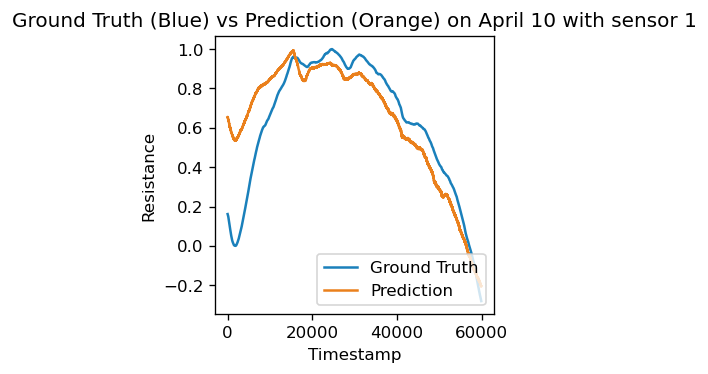

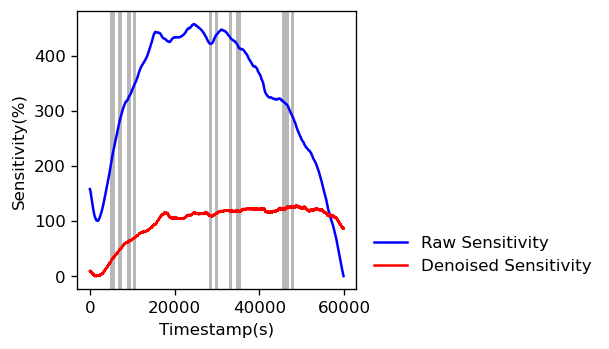

There are 12 stoat events!


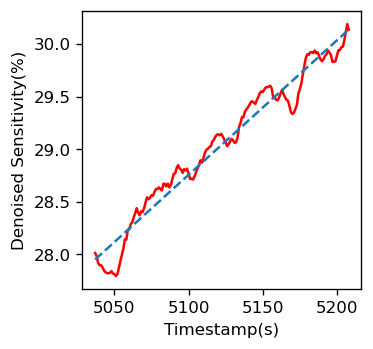

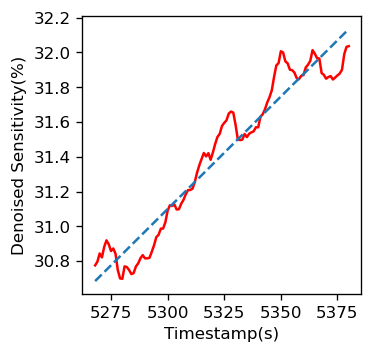

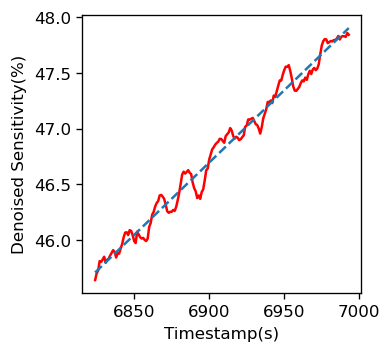

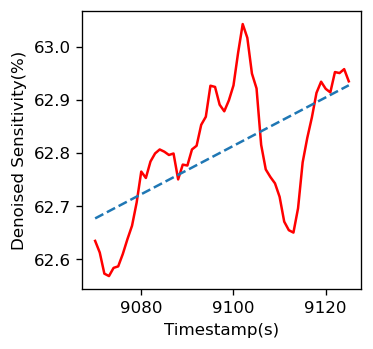

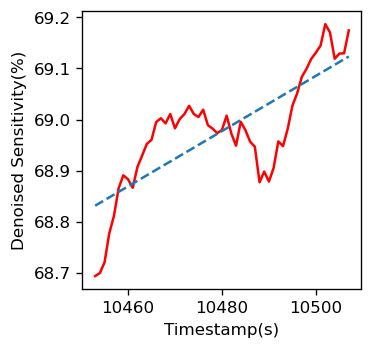

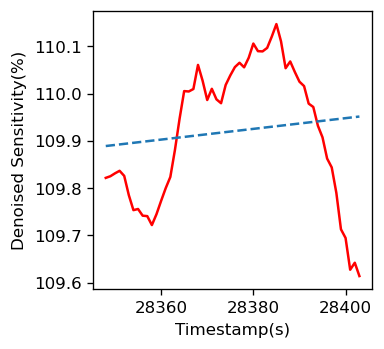

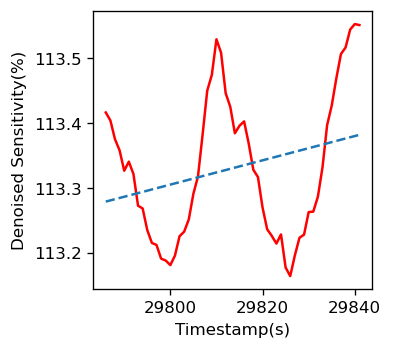

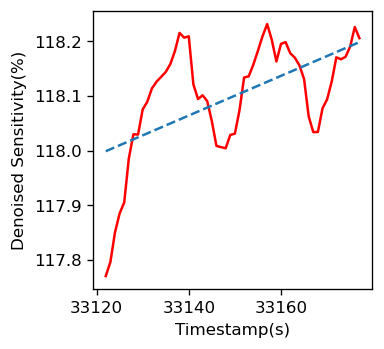

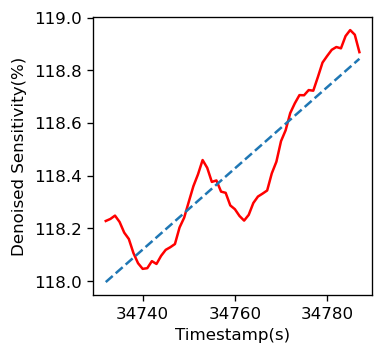

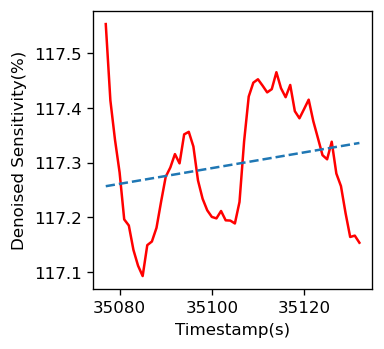

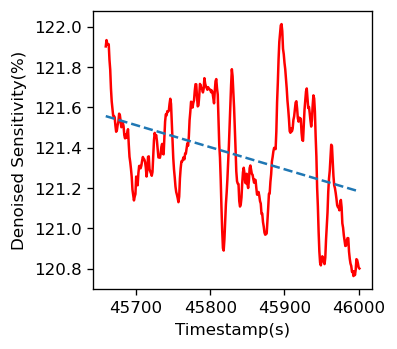

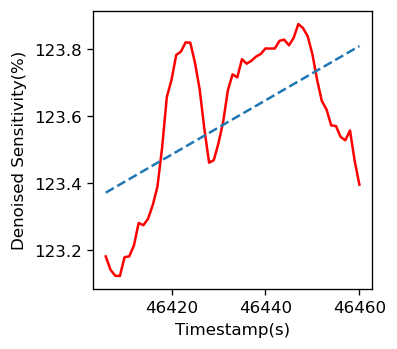

Success rate is 0.9166666666666666
Save to: c:\Users\zche677\OneDrive - The University of Auckland\Desktop\Working_Directory\predator_detection_clean\results\averaged_denoise_results.csv


In [13]:
#plt.rcParams.update({"figure.figsize": (5, 3), "figure.dpi": 120}) # matplotlib plot size
plt.rcParams.update({"figure.figsize": (3, 3), "figure.dpi": 120}) # matplotlib plot size
success_num, events_num, ground_truth_y, model_pred, events = run_denoise_experiments(data_dict_for_denoise, 2, True, 120, data_ind_pairs = SENSOR_INDS_DICT[DATES[2]], 
                        is_standard_scaler = False, moving_average_direction = "center",
                        plot_detailed_results = True, plot_general_results= True, seed=SEED)

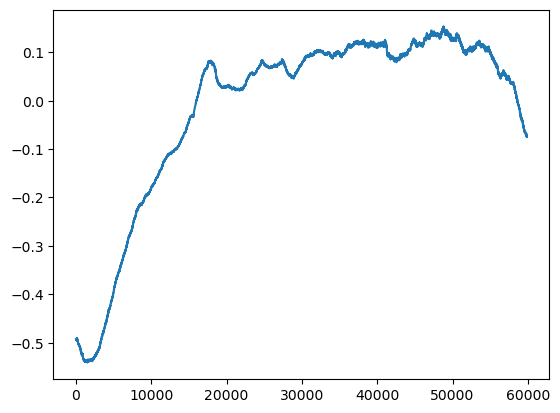

In [93]:
denoised_r = ground_truth_y - model_pred

plt.plot(denoised_r)

In [94]:
general_plot_dict = {}
general_plot_dict["Time Index"] = list(range(1, denoised_r.shape[0]+1, 1))
general_plot_dict["Denoised Resistance"] = denoised_r
general_plot_dict["Ground Truth Resistance"] = ground_truth_y
general_plot_dict["Model Prediction Resistance"] = model_pred
for e_id in range(len(events)):
    general_plot_dict["Event " + str(e_id + 1)] = [events[e_id][0], events[e_id][-1]] + [np.nan] * (denoised_r.shape[0]-2)

general_plot_df = pd.DataFrame(general_plot_dict)

In [95]:
general_plot_df

,Time Index,Denoised Resistance,Ground Truth Resistance,Model Prediction Resistance,Event 1,Event 2,Event 3,Event 4,Event 5,Event 6,Event 7,Event 8,Event 9,Event 10,Event 11,Event 12
0,1,-0.493364,0.161831,0.655195,5037.0,5268.0,6824.0,9070.0,10453.0,28348.0,29786.0,33122.0,34732.0,35077.0,45659.0,46406.0
1,2,-0.493501,0.161643,0.655144,5209.0,5381.0,6994.0,9126.0,10508.0,28404.0,29842.0,33178.0,34788.0,35133.0,46002.0,46461.0
2,3,-0.493575,0.161441,0.655016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,-0.493757,0.161224,0.654981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,-0.494128,0.161038,0.655166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59876,59877,-0.073726,-0.279582,-0.205857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59877,59878,-0.073945,-0.279693,-0.205748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59878,59879,-0.074166,-0.279788,-0.205622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59879,59880,-0.074450,-0.279884,-0.205434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
general_plot_df.to_csv("denoised_example_plot.csv")

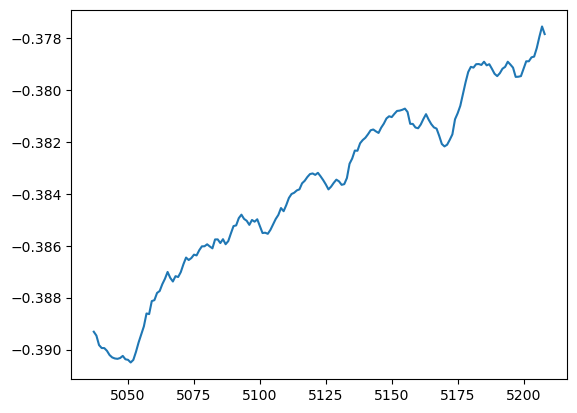

In [97]:
plt.plot(general_plot_df["Denoised Resistance"][events[0][0] : events[0][-1]])

plt.rcParams.update({"figure.figsize": (15, 6), "figure.dpi": 120}) # matplotlib plot size
for date_ind in da_inds:
    for standard in [True, False]:
        for direction in ma_dirs:
            for ma in ma_vals:

                print(DATES[date_ind], ma, standard, direction)
                run_denoise_experiments(data_dict_for_denoise, date_ind, True, ma, data_ind_pairs = SENSOR_INDS_DICT[DATES[date_ind]], is_standard_scaler = standard, moving_average_direction = direction, seed=SEED)
                #print(DATES[date_ind], ma, direction)

In [98]:
#for ma in [0, 15, 30, 60, 120, 240]
    #run_denoise_experiments(1, ma)

In [99]:
# plt.rcParams.update({"figure.figsize": (15, 6), "figure.dpi": 120}) # matplotlib plot size

# lstm_models = []


# #for d_ind in range(1,3,1):
# for d_ind in range(1,3,1):
#     for data_ind_pair in DATA_INDS:
#         X_train, X_valid, X_test, y_train, y_valid, y_test, _, _, scalers = preprocess_one_day_data_r(d_ind, WINDOW_SIZE, VALID_PER, TEST_PER, remove_resist = True, is_random_shuffle = True, use_diff = False, is_control = True, scalers = None, data_ind = data_ind_pair[1], moving_average = 0)
#         lstm_model, lstm_losses = grid_search_rnn(X_train, y_train, X_valid, y_valid, "LSTM", DEVICE, SEED)
#         lstm_models.append(lstm_models)

#         plt.plot(lstm_losses)
#         plt.show()

#         X_time, y_time = get_stoat_events(d_ind, WINDOW_SIZE)
#         X_train_e, X_valid_e, X_test_e, y_train_e, y_valid_e, y_test_e, _, _ , _= preprocess_one_day_data_r(d_ind, WINDOW_SIZE, VALID_PER, TEST_PER, remove_resist = True, is_random_shuffle = False, use_diff = False, is_control = False, scalers = None, data_ind = data_ind_pair[0], moving_average = 0)
#         # Different Scalers for experiments and control groups
#         X_all_e = torch.cat((X_train_e, X_valid_e, X_test_e), 0)
#         y_all_e = torch.cat((y_train_e, y_valid_e, y_test_e), 0)

        
#         plot_model_predictions(lstm_model(X_test.to(DEVICE)), y_test.cpu(), DATES[d_ind], data_ind_pair[1])
        
#         plot_model_predictions(lstm_model(X_all_e.to(DEVICE)), y_all_e.cpu(), DATES[d_ind], data_ind_pair[0])
        
#         plot_results(lstm_model(X_all_e.to(DEVICE)), y_all_e.cpu(), y_time, DATES[d_ind], data_ind_pair)

In [100]:
# plt.rcParams.update({"figure.figsize": (15, 6), "figure.dpi": 120}) # matplotlib plot size

# lstm_models = []


# for d_ind in range(4):
#     X_train, X_valid, X_test, y_train, y_valid, y_test, _, _, scalers = preprocess_one_day_data_r(d_ind, WINDOW_SIZE, VALID_PER, TEST_PER, remove_resist = True, is_random_shuffle = True, use_diff = True, is_control = True, scalers = None)
#     lstm_model, lstm_losses = grid_search_rnn(X_train, y_train, X_valid, y_valid, "LSTM", DEVICE, SEED)
#     lstm_models.append(lstm_models)

#     plt.plot(lstm_losses)
#     plt.show()

#     X_time, y_time = get_stoat_events(d_ind, WINDOW_SIZE)
#     X_train_e, X_valid_e, X_test_e, y_train_e, y_valid_e, y_test_e, _, _ , _= preprocess_one_day_data_r(d_ind, WINDOW_SIZE, VALID_PER, TEST_PER, remove_resist = True, is_random_shuffle = False, use_diff = True, is_control = False, scalers = scalers)
#     # Same Scalers for experiments and control groups with use_diff = True
#     X_all_e = torch.cat((X_train_e, X_valid_e, X_test_e), 0)
#     y_all_e = torch.cat((y_train_e, y_valid_e, y_test_e), 0)

    
#     plot_model_predictions(lstm_model(X_test.to(DEVICE)), y_test.cpu(), DATES[d_ind])
    
#     plot_model_predictions(lstm_model(X_all_e.to(DEVICE)), y_all_e.cpu(), DATES[d_ind])
    
#     plot_results(lstm_model(X_all_e.to(DEVICE)), y_all_e.cpu(), y_time, DATES[d_ind])

In [101]:
DATA_DICT[DATES[0]][0][0]["Resistance"]
DATA_DICT[DATES[0]][0][3]["Resistance"]

0        16467.6851
1        16433.7916
2        16425.3365
3        16408.4506
4        16400.0197
            ...    
64450    16408.4506
64451    16408.4506
64452    16416.8905
64453    16408.4506
64454    16408.4506
Name: Resistance, Length: 64454, dtype: float64